In [1]:
pip install ipykernel

Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import numpy as np
from collections import deque



In [1]:
import matplotlib.pyplot as plt

<>:225: SyntaxWarning: invalid escape sequence '\d'
<>:225: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Noman\AppData\Local\Temp\ipykernel_13308\3570834706.py:225: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("one_bin_datasets\dataset_40.csv")


Initial number of bins: 2604
After Tabu Search: 277
After Actor-Critic Optimization: 176


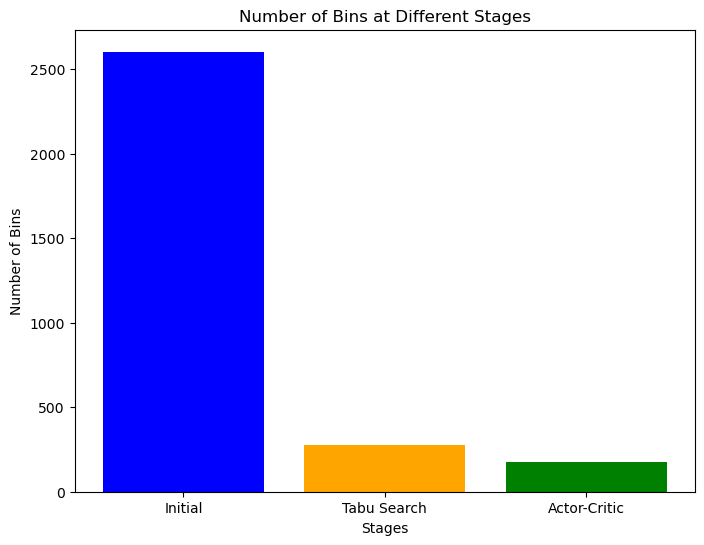

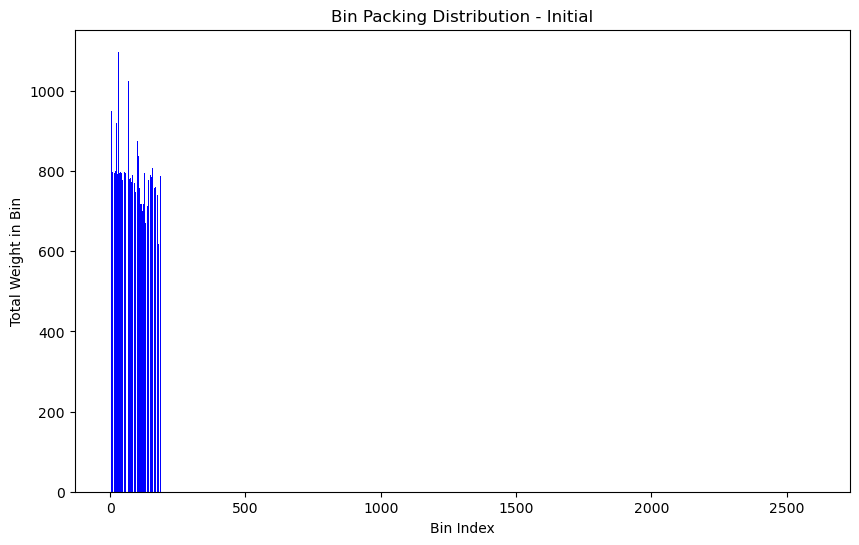

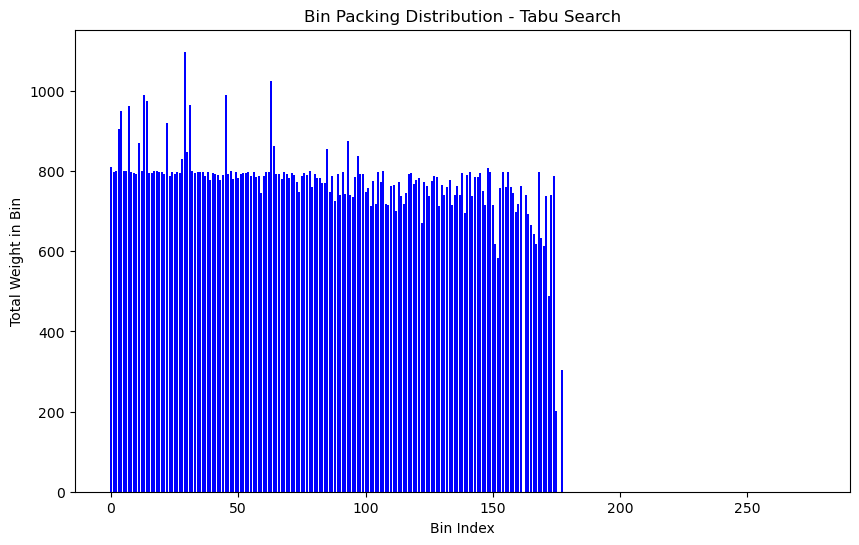

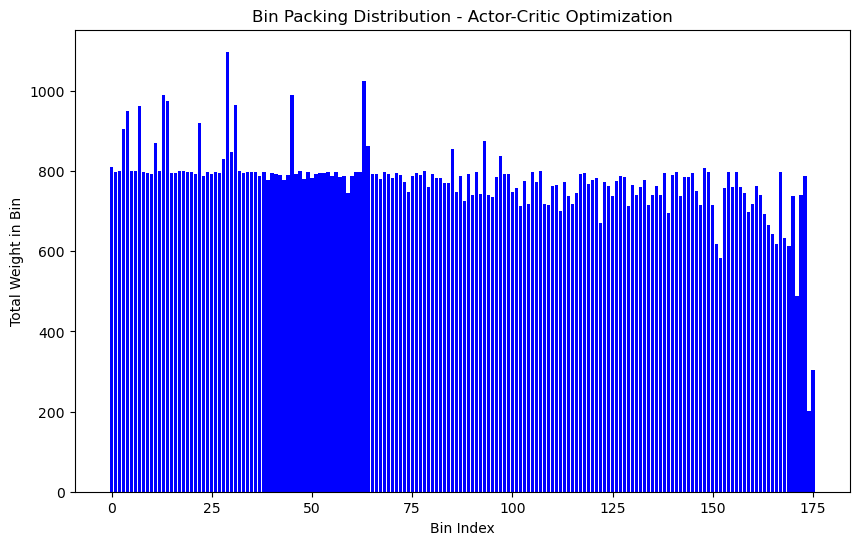

In [16]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

# Step 1: Initialize Parameters
def initialize_parameters(bin_capacity):
    parameters = {
        "bin_capacity": bin_capacity,
        "tabu_tenure": 15,
        "max_iterations": 50000, 
        "operator_pool": ["mutation", "crossover", "swap"],
        "gamma": 0.99, 
        "alpha": 0.01, 
    }
    return parameters

# Step 2: Initial Solution Generation
def initial_solution(items, bin_capacity):
    bins = []
    current_bin = []
    current_weight = 0

    for item in items:
        if current_weight + item <= bin_capacity:
            current_bin.append(item)
            current_weight += item
        else:
            bins.append(current_bin)
            current_bin = [item]
            current_weight = item
    bins.append(current_bin)

    return bins

# Step 3: Tabu Search Implementation
def tabu_search(bins, bin_capacity, parameters):
    best_solution = bins
    best_fitness = len(bins)
    tabu_list = deque(maxlen=parameters["tabu_tenure"])

    for _ in range(parameters["max_iterations"]):
        candidate_solutions = generate_neighbors(best_solution, bin_capacity, parameters["operator_pool"])
        candidate_solutions = [s for s in candidate_solutions if s not in tabu_list]
        if not candidate_solutions:
            continue
        candidate_fitness = [len(solution) for solution in candidate_solutions]
        best_candidate = candidate_solutions[np.argmin(candidate_fitness)]

        if len(best_candidate) < best_fitness:
            best_solution = best_candidate
            best_fitness = len(best_candidate)

        tabu_list.append(best_candidate)

    return best_solution

def generate_neighbors(solution, bin_capacity, operator_pool):
    neighbors = []

    for operator in operator_pool:
        new_solution = None
        if operator == "mutation":
            new_solution = mutation(solution, bin_capacity)
        elif operator == "crossover":
            new_solution = crossover(solution)
        elif operator == "swap":
            new_solution = swap(solution)
        
        # Ensure new_solution is valid and non-empty
        if new_solution and new_solution != solution:
            neighbors.append(new_solution)

    return neighbors

# Operators
def mutation(solution, bin_capacity):
    # Implement mutation operation
    mutated_solution = solution.copy()
    if mutated_solution:
        random_bin = random.choice(mutated_solution)
        if random_bin:
            item = random.choice(random_bin)
            random_bin.remove(item)
            for b in mutated_solution:
                if sum(b) + item <= bin_capacity:
                    b.append(item)
                    break
            if not random_bin:
                mutated_solution.remove(random_bin)
    return mutated_solution

def crossover(solution):
    crossover_solution = solution.copy()
    if len(crossover_solution) >= 2:
        bin1, bin2 = random.sample(crossover_solution, 2)

        if bin1 and bin2:
            item1, item2 = random.choice(bin1), random.choice(bin2)
            
            bin1.remove(item1)
            bin2.remove(item2)
            bin1.append(item2)
            bin2.append(item1)

    return crossover_solution


def swap(solution):
    swapped_solution = solution.copy()

    non_empty_bins = [b for b in swapped_solution if b]

    if len(non_empty_bins) >= 2:
        bin1, bin2 = random.sample(non_empty_bins, 2)

        if bin1 and bin2:
            item1, item2 = random.choice(bin1), random.choice(bin2)
            
            bin1.remove(item1)
            bin2.remove(item2)
            bin1.append(item2)
            bin2.append(item1)

    return swapped_solution

# Step 4: Refined Actor-Critic Optimization
def actor_critic_optimization(solution, operator_pool, parameters):
    critic_values = np.zeros(len(operator_pool))  # Critic estimates for each operator
    state = evaluate_solution(solution)  # Current state is the number of bins

    epsilon = 0.1  # Exploration rate

    for _ in range(parameters["max_iterations"]):
        # Choose action using epsilon-greedy strategy (exploration vs. exploitation)
        if random.random() < epsilon:
            operator_index = random.randint(0, len(operator_pool) - 1)
        else:
            operator_index = np.argmax(critic_values)
        
        selected_operator = operator_pool[operator_index]

        # Apply the selected operator to generate a new solution
        if selected_operator == "mutation":
            new_solution = mutation(solution, parameters["bin_capacity"])
        elif selected_operator == "crossover":
            new_solution = crossover(solution)
        elif selected_operator == "swap":
            new_solution = swap(solution)

        new_state = evaluate_solution(new_solution)  # New state is the number of bins

        # Define reward based on change in number of bins and bin usage efficiency
        bin_efficiency = sum(sum(bin) for bin in new_solution) / (len(new_solution) * parameters["bin_capacity"])
        reward = (state - new_state) + 0.1 * bin_efficiency  # Encourage fewer bins and well-packed bins

        # Update the critic values using the Bellman equation
        critic_values[operator_index] += parameters["alpha"] * (
            reward + parameters["gamma"] * np.max(critic_values) - critic_values[operator_index]
        )

        # Update state and solution
        state = new_state
        solution = new_solution

    return solution


# Step 5: Evaluation
def evaluate_solution(solution):
    return len(solution)

# Step 6: Graph plotting functions
def plot_bins(bins, stage):
    bin_lengths = [sum(bin) for bin in bins]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(bin_lengths)), bin_lengths, color='blue')
    plt.title(f'Bin Packing Distribution - {stage}')
    plt.xlabel('Bin Index')
    plt.ylabel('Total Weight in Bin')
    plt.show()


# Step 7: Main Function with Graphs
def main(dataset):
    bin_capacity = 800
    parameters = initialize_parameters(bin_capacity)

    # Initial solution
    initial_bins = initial_solution(dataset, bin_capacity)
    initial_count = evaluate_solution(initial_bins)
    
    # Tabu search optimization
    optimized_bins = tabu_search(initial_bins, bin_capacity, parameters)
    tabu_count = evaluate_solution(optimized_bins)
    
    # Actor-critic optimization
    final_solution = actor_critic_optimization(optimized_bins, parameters["operator_pool"], parameters)
    final_count = evaluate_solution(final_solution)

    # Print results
    print(f"Initial number of bins: {initial_count}")
    print(f"After Tabu Search: {tabu_count}")
    print(f"After Actor-Critic Optimization: {final_count}")

    # Plot number of bins at each stage
    stages = ['Initial', 'Tabu Search', 'Actor-Critic']
    bin_counts = [initial_count, tabu_count, final_count]

    plt.figure(figsize=(8, 6))
    plt.bar(stages, bin_counts, color=['blue', 'orange', 'green'])
    plt.title('Number of Bins at Different Stages')
    plt.xlabel('Stages')
    plt.ylabel('Number of Bins')
    plt.show()

    # Plot bin distribution at each stage
    plot_bins(initial_bins, "Initial")
    plot_bins(optimized_bins, "Tabu Search")
    plot_bins(final_solution, "Actor-Critic Optimization")

# Load dataset and execute
df = pd.read_csv("one_bin_datasets\dataset_40.csv")
small_dataset = df["Weight"].tolist()

main(small_dataset)
